# Vehicle Classification Model

This file contains the code for creatiing, training, and compressing the CNN used for the thesis project.

In [7]:
DATASET_PATH = "dataset_mix_aug.csv"
INPUT_SHAPE = (16, 8, 1)

MODEL_NAME = "619_kb_model"

GENERATE_KERAS_MODLE = False
KERAS_MODEL_NAME = f"{MODEL_NAME}.h5"  # Try using .keras instead.

TF_LITE_MODEL_FILE_NAME = f"{MODEL_NAME}.tflite"

## Imports

Place all imports in this section.

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, 
    InputLayer, GlobalAveragePooling2D, AveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [9]:
print(tf.__version__)

2.18.0


In [10]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

### Connect to Google Drive

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

# Helper Functions

In [12]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [13]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Importa Data

In [14]:
df = pd.read_csv(DATASET_PATH, header=None)                     # Note that these should be no header present.
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float32)            # All but last column as float32 (required by MCU)
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [15]:
dataset = dataset.reshape(dataset.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2])

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {INPUT_SHAPE}")

Dataset shape: (5222650, 16, 8, 1)
Labels shape: (5222650,)
Input shape: (16, 8, 1)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 3342496
Validation set length: 835624
Testing set length: 1044530


In [17]:
print(x_train.shape)
# Get mean of each value in x_train
mean = np.mean(x_train)
print(mean)
# Get standard deviation of each value in x_train
std = np.std(x_train)
print(std)
# Normalize the dataset
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std


(3342496, 16, 8, 1)
-5.771239
24.030207


In [18]:
# Apply clipping at -3 and 3
x_train = np.clip(x_train, -3, 3)
x_val = np.clip(x_val, -3, 3)
x_test = np.clip(x_test, -3, 3)

In [19]:
# Load CSV file called test.csv
#df_test = pd.read_csv("test.csv", header=None)  # Note that these should be no header present.
#dataset_test = df_test.iloc[:, :-1].to_numpy(dtype=np.float32)  # All but last column as float32 (required by MCU)
#labels_set_test = df_test.iloc[:, -1].to_numpy(dtype=str)  # Last column as string

#dataset_test = (dataset_test - mean) / std
# Apply clipping at -3 and 3
#dataset_test = np.clip(dataset_test, -3, 3)
# Turn into int8 [-128, 127]
#dataset_test = np.round((dataset_test / 3) * 127).astype(np.int8)

In [20]:
#dataset_test[6]

In [21]:
# Calculate class weights (based on training data).
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [22]:
print(f"Classes: {np.unique(labels_set)}")
print(f"Class weights: {dist_class_weight}")

# Print out the amount of each class.
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

Classes: ['Car' 'Comm' 'Motorcycle' 'background']
Class weights: {0: np.float64(0.7314123660808066), 1: np.float64(1.021185695012025), 2: np.float64(1.066565237813221), 3: np.float64(1.3967666015886175)}
Training class distribution: {np.str_('Car'): np.int64(1142480), np.str_('Comm'): np.int64(818288), np.str_('Motorcycle'): np.int64(783472), np.str_('background'): np.int64(598256)}


In [23]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

## Model


### Helper Functions

In [24]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # 0.1 or 0.2
        metrics=['categorical_accuracy']
    )
    model.summary()

In [25]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [26]:
def printConfusionMatrix(model, x_test, y_test, labels_set):
    y_train_int = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels for y_train
    y_test_int = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels for y_test

    y_pred_prob = model.predict(x_test)

    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax probabilities to class indices

    # Ensure that the labels are in 1D arrays (class indices) before passing to confusion_matrix
    print(f"y_train_int shape: {y_train_int.shape}")
    print(f"y_test_int shape: {y_test_int.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    # Define your class labels (ensure they match the number of classes)
    class_names = np.unique(labels_set)  # Assuming labels_set contains class names

    # Generate confusion matrix
    cm = confusion_matrix(y_test_int, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualize the normalized confusion matrix with proper labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [27]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [28]:
def evaluate_tflite_model(model_path, x_test, y_test):

  interpreter = tf.lite.Interpreter(model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  predictions = []
  for i in range(len(x_test)):
    # Set the input tensor.
    interpreter.set_tensor(input_details[0]['index'], [x_test[i]])

    # Run inference.
    interpreter.invoke()

    # Get the output tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

  # Convert predictions to class labels
  predicted_labels = [np.argmax(prediction[0]) for prediction in predictions]
  true_labels = [np.argmax(label) for label in y_test]

  # Calculate accuracy
  correct_predictions = sum([1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted])
  accuracy = correct_predictions / len(true_labels)

  # Print the accuracy
  print(f"Accuracy: {accuracy}")

  # Print a classification report
  print(classification_report(true_labels, predicted_labels))

### Create, train, compile, test

In [29]:
model = keras.Sequential([
    InputLayer(shape=INPUT_SHAPE),

    # 16 8
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    # 8 4
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    #4 2
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),

    # Feature Pooling (Combining Max & Average Pooling)
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)), activation="softmax") # Softmax barely increase size.
])

I0000 00:00:1744651627.876925   22134 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1744651627.877212   22134 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4099 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [30]:
compileModel(model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 8, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,692 (619.89 KB)

 Trainable params: 158,180 (617.89 KB)

 Non-trainable params: 512 (2.00 KB)

2025-04-14 19:27:10.640352: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1711357952 exceeds 10% of free system memory.
2025-04-14 19:27:12.090909: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1711357952 exceeds 10% of free system memory.


Epoch 1/8


I0000 00:00:1744651637.042825   22452 service.cc:148] XLA service 0x7251c40087c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744651637.042861   22452 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-14 19:27:17.164400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744651637.703251   22452 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-14 19:27:18.113632: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[256,32,16,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,1,16,8]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend

   26/13057 ━━━━━━━━━━━━━━━━━━━━ 1:22 6ms/step - categorical_accuracy: 0.3835 - loss: 1.6260

I0000 00:00:1744651641.275645   22452 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13049/13057 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5996 - loss: 1.0961

2025-04-14 19:28:26.626582: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[160,32,16,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,1,16,8]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-14 19:28:26.642445: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[160,32,16,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,32,16,8]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

13057/13057 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5997 - loss: 1.0960

2025-04-14 19:28:29.961260: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427839488 exceeds 10% of free system memory.
2025-04-14 19:28:30.291572: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427839488 exceeds 10% of free system memory.
2025-04-14 19:28:30.782003: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[256,32,16,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,1,16,8]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-14 19:28:30.799674: I external/local_xla/xla/service/gpu/autotuning/conv_

13057/13057 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - categorical_accuracy: 0.5997 - loss: 1.0960 - val_categorical_accuracy: 0.6700 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 2/8
13057/13057 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - categorical_accuracy: 0.6940 - loss: 0.9634 - val_categorical_accuracy: 0.7133 - val_loss: 0.9709 - learning_rate: 0.0010
Epoch 3/8
13057/13057 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - categorical_accuracy: 0.7213 - loss: 0.9345 - val_categorical_accuracy: 0.7299 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 4/8
13057/13057 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - categorical_accuracy: 0.7369 - loss: 0.9178 - val_categorical_accuracy: 0.7411 - val_loss: 0.9382 - learning_rate: 0.0010
Epoch 5/8
13057/13057 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - categorical_accuracy: 0.7468 - loss: 0.9068 - val_categorical_accuracy: 0.7435 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 6/8
13057/13057 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - categorical_accuracy: 0.7536 - loss: 0.8988 - val_ca

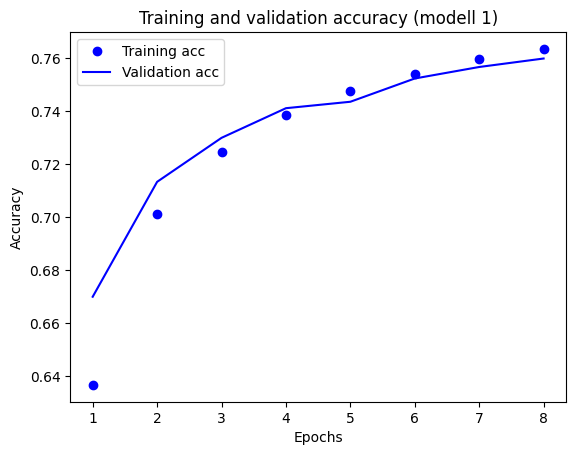

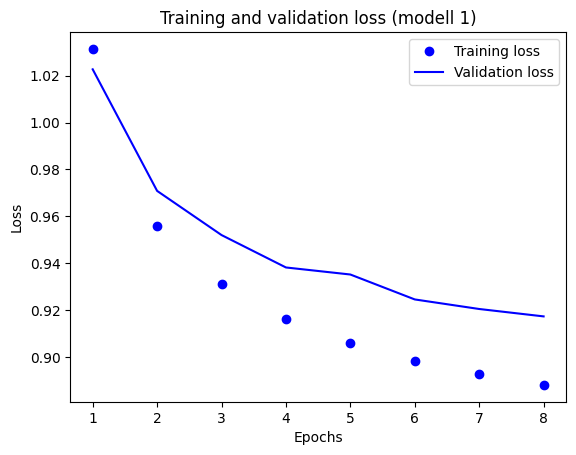

In [31]:
fitModel(model, x_train, y_train, x_val, y_val, 8, True, dist_class_weight, 1, 256)

In [32]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

2025-04-14 19:37:26.520014: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 534799360 exceeds 10% of free system memory.
2025-04-14 19:37:27.027248: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,16,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,16,8]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-14 19:37:27.052743: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,8,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,8,4]{3,2,1,

32642/32642 - 86s - 3ms/step - categorical_accuracy: 0.7603 - loss: 0.9171
Test accuracy: 0.7603285908699036


32642/32642 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step
y_train_int shape: (3342496,)
y_test_int shape: (1044530,)
y_pred shape: (1044530,)


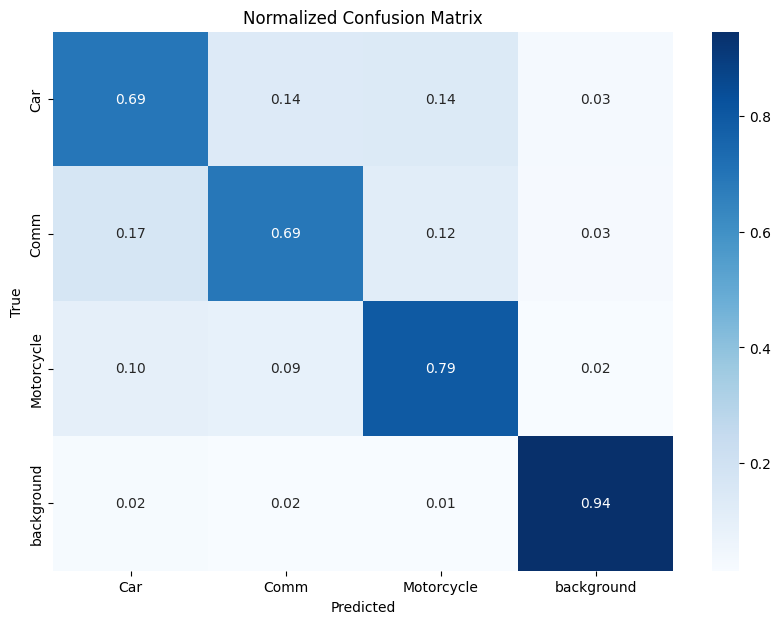

In [33]:
printConfusionMatrix(model, x_test, y_test, labels_set)

# Save & Compress model

### Keras Model

Generating the Keras model is not required, thus the boolean check.

In [34]:
if GENERATE_KERAS_MODLE:
    model.save(KERAS_MODEL_NAME)
    print("Keras model saved: ", KERAS_MODEL_NAME)
    convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

In [35]:
x_train.shape

(3342496, 16, 8, 1)

### TF Lite model

The TF Lite model is the main model to be used. This is where compression happens and thus also makes it important to test once again after compression. Once done, it's transformed into a CPP file to be implemented into pico-tfmicro.

In [36]:
# Convert into TFLite model.
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimizations.
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
## NOT UINT8 but INT8
tf_lite_converter.inference_input_type = tf.int8
tf_lite_converter.inference_output_type = tf.int8

num_calibration_images = 2000000
calibration_indexes   = np.random.choice(x_train.shape[0], num_calibration_images, replace=False)
def representative_dataset_gen():
  for i in range(num_calibration_images):
    yield [x_train[calibration_indexes[i: i + 1]]]

tf_lite_converter.representative_dataset = representative_dataset_gen

# Grab model and save it.
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

print("TFLite model saved: ", TF_LITE_MODEL_FILE_NAME)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

# Print model input and output shape for debugging.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# Evaluate the TFLite model.
x_int8 = np.round((x_test / 3) * 127).astype(np.int8)
evaluate_tflite_model(TF_LITE_MODEL_FILE_NAME, x_int8, y_test)

INFO:tensorflow:Assets written to: /tmp/tmphbscdbyx/assets


INFO:tensorflow:Assets written to: /tmp/tmphbscdbyx/assets


Saved artifact at '/tmp/tmphbscdbyx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 8, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  125711715054896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713339696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713347968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713348672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713343392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713345680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713342336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713349552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713349904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713351488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125711713350080: 

/home/fridh/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1744652418.347552   22134 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744652418.347577   22134 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-14 19:40:18.347997: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphbscdbyx
2025-04-14 19:40:18.350747: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-14 19:40:18.350765: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmphbscdbyx
I0000 00:00:1744652418.368787   22134 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-04-14 19:40:18.372837: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-14 19:40:18.4901

TFLite model saved:  619_kb_model.tflite
File size: 176.695 Kilobytes
Input Shape: [ 1 16  8  1]
Input Type: <class 'numpy.int8'>
Output Shape: [1 4]
Output Type: <class 'numpy.int8'>
Accuracy: 0.7298517036370425
              precision    recall  f1-score   support

           0       0.72      0.69      0.71    357025
           1       0.67      0.64      0.65    255715
           2       0.68      0.74      0.71    244835
           3       0.89      0.91      0.90    186955

    accuracy                           0.73   1044530
   macro avg       0.74      0.75      0.74   1044530
weighted avg       0.73      0.73      0.73   1044530



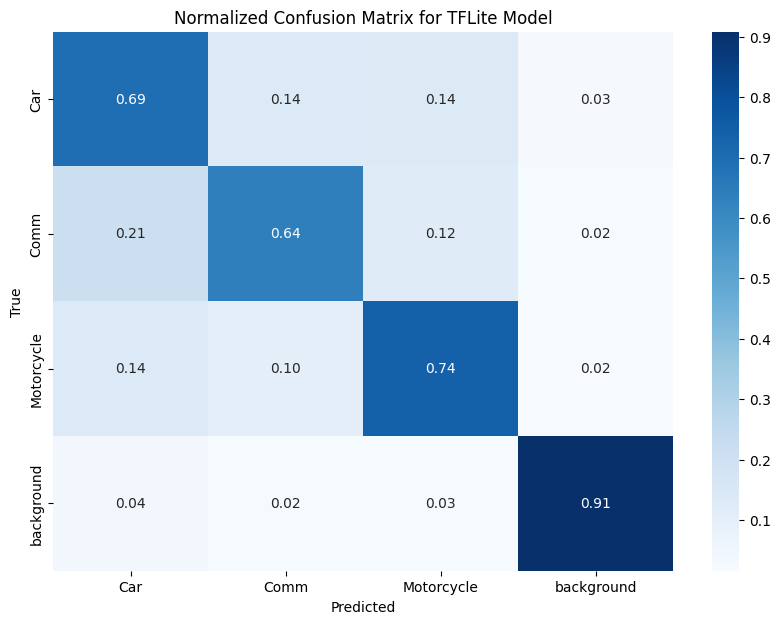

In [37]:
# Load the TFLite model.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the test data for inference.
x_test_int8 = np.round((x_test / 3) * 127).astype(np.int8)

# Perform inference on the test set.
y_pred = []
for i in range(len(x_test_int8)):
    interpreter.set_tensor(input_details[0]['index'], [x_test_int8[i]])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred.append(np.argmax(output_data))

# Convert predictions and true labels to integer format.
y_true = [np.argmax(label) for label in y_test]

# Generate confusion matrix.
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix.
plt.figure(figsize=(10, 7))
class_names = np.unique(labels_set)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix for TFLite Model')
plt.show()

In [38]:
# Save the TF Lite model as a C++ array using xxd.
# This is required to implement the model using pico-tfmicro.
# Note that the file size from this is larger than the tflite file size,
# but won't increase the story size of the model when implemented in C++.
!xxd -i {TF_LITE_MODEL_FILE_NAME} > {MODEL_NAME}.cpp